In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    npimg = npimg-np.amin(npimg)
    npimg = npimg/np.amax(npimg)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
        
    plt.show()


In [3]:
# We will save the results here
outf="./dcgan_results"

In [4]:
#manualSeed = random.randint(1, 10000)
manualSeed = 4532
print("Random Seed: ", manualSeed)
random.seed(manualSeed)

torch.manual_seed(manualSeed)
cudnn.benchmark = True

use_cuda=True
if use_cuda:
    torch.cuda.manual_seed_all(manualSeed)

if torch.cuda.is_available() and not use_cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

Random Seed:  4532


In [5]:
imageSize = 64 # square images for now!
dataroot = './images' 
#dataroot = "./geom_pics_dataset"

# folder dataset
dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Scale(imageSize),
                                   transforms.CenterCrop(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
batchSize= 32
workers = 2
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))

In [7]:
print('num of batches:', dataloader.__len__())
print('num Of Images:', dataloader.__len__()*batchSize)

num of batches: 163
num Of Images: 5216


In [8]:
# this example demonstrates how we can load a new batch of data
dataiter = iter(dataloader)
data= dataiter.next()
data[0]=(data[0]+1)/2
print(len(data))
print(data[0].size(),data[1].size())

2
torch.Size([32, 3, 64, 64]) torch.Size([32])


In [9]:
#labels are in data[1][:]
data[1][0:5]

tensor([0, 0, 0, 0, 0])

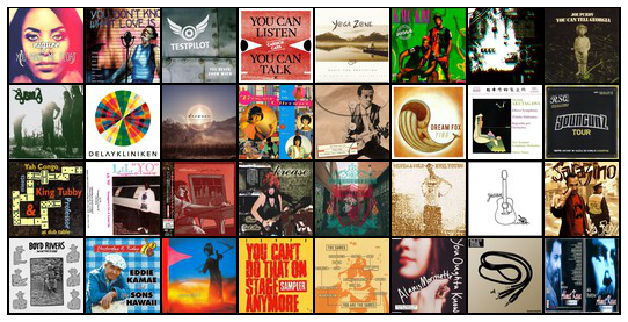

In [10]:
# show some examples from the original data
# images are in data[0][:]
show(make_grid(data[0]))

In [11]:
ngpu = int(1) # use one GPU
nz = int(100) # code dimension (This is the() random noise) input dimension of the generator network)
ngf = int(500) # output dimension of the generator network
ndf = int(500) # input dim (image size) for the discriminator net
nc = 3 # number of input channels (e.g. 3 for RGB channels)

In [12]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
# Let us create the Generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [14]:
netG = _netG(ngpu)
netG.apply(weights_init)

# if we want to load a saved netG, we can do it here:
#savednetG=outf+"/netG_epoch_39.pth"
#netG.load_state_dict(torch.load(savednetG))
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 4000, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(4000, 2000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(2000, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(1000, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(500, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh(

In [15]:
# Let us create the Discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [16]:
netD = _netD(ngpu)
netD.apply(weights_init)

# If we want to load a saved netD, we can do it here:
#savednetD=outf+"/netD_epoch_39.pth"
#netD.load_state_dict(torch.load(savednetD))
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(500, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(1000, 2000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(2000, 4000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(4000, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [17]:
# Binary Cross Entropy between the target (p, 1-p) and the output (q,1-q) distributions
criterion = nn.BCELoss()

In [18]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize) # this will be the input of the Discriminator network

noise = torch.FloatTensor(batchSize, nz, 1, 1) # this will be the input of the Generator network

# We will also use some "fixed" noise to monitor the progess of the generated data
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)

label = torch.FloatTensor(batchSize)


In [19]:
#helps to have real = 0 and fake = 1 apparently
real_label = 0
fake_label = 1

In [20]:
# put NetD, netG, the criterion, input, and noise to the GPUs
if use_cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [21]:
fixed_noise = Variable(fixed_noise)

In [22]:
# setup optimizer

beta1 =0.5
lr=0.0002

optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

#optimizerD = optim.SGD(netD.parameters(), lr=0.001, momentum=0.9)
#optimizerG = optim.SGD(netG.parameters(), lr=0.001, momentum=0.9)


### One Step of Optimization

In [23]:
############################
# (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
###########################
# train with real
netD.zero_grad()
real_cpu, _ = data # data[0] = images, data[1] =labels (triangle, ellipse, rectangle). Labels are not important
batch_size = real_cpu.size(0)
if use_cuda:
    real_cpu = real_cpu.cuda() # move the image data to the GPUs
input.resize_as_(real_cpu).copy_(real_cpu) #copy the image data to input variable
print("input:", input.size())
label.resize_(batch_size).fill_(real_label) #since this is all real data add them "real_label" label
inputv = Variable(input)
labelv = Variable(label)


input: torch.Size([32, 3, 64, 64])


In [24]:
inputv.size()

torch.Size([32, 3, 64, 64])

In [25]:
output = netD(inputv) # caclulate the predicitions of netD network:
output.size()

torch.Size([32])

In [26]:
print(output[0:5], labelv[0:5]) # We want the predicited output to be all ones (real data)

tensor([0.3823, 0.8839, 0.4830, 0.8656, 0.7533], device='cuda:0',
       grad_fn=<SliceBackward>) tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [27]:
# We want the output of netD(real images) to be all ones.
# Let us caclulate the error
errD_real = criterion(output, labelv)
# We want the error to be as small as possible
print("Error of Discriminator on real data: ",errD_real)

Error of Discriminator on real data:  tensor(2.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [28]:
#Let D_x be the mean of the outputs on real data. 
#Since we used real data, we want D_x to be close to 1
D_x = output.data.mean()
print(D_x)

tensor(0.7400, device='cuda:0')


In [29]:
# Let us caculate the gradient of errD_real. 
errD_real.backward()

In [30]:
# Now we will train with fake data
noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)

In [31]:
#  Generate fake images from noise
fake = netG(noisev)
fake.size()

torch.Size([32, 3, 64, 64])

In [32]:
# add "fake_label" labels to the fake images
labelv = Variable(label.fill_(fake_label))
labelv.size()

torch.Size([32])

In [33]:
output = netD(fake.detach())
output.size()

torch.Size([32])

In [34]:
#We want the output of netD(fake images) to be all zeros
print(output[0:5], labelv[0:5])

tensor([0.8370, 0.7277, 0.9549, 0.9716, 0.4438], device='cuda:0',
       grad_fn=<SliceBackward>) tensor([1., 1., 1., 1., 1.], device='cuda:0')


In [35]:
# Calculate the error of the Discriminiator network on the fake data
errD_fake = criterion(output, labelv)
errD_fake
# We want this error to be as small as possible

tensor(1.2176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [36]:
# Calculate the gradient of errD_fake
errD_fake.backward()

In [37]:
#Let D_G_z1 be the mean of the output of the Discriminator on fake data
# We want D_G_z1 to be close to 0
D_G_z1 = output.data.mean()
D_G_z1

tensor(0.5545, device='cuda:0')

In [38]:
# The combined error:
errD = errD_real + errD_fake
errD
# We want this to be as close to zero as possible

tensor(3.7461, device='cuda:0', grad_fn=<AddBackward0>)

In [39]:
optimizerD.step()

In [40]:
netG.zero_grad()

In [41]:
# The Generator wants to trick the Discriminator
labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
labelv.size()

torch.Size([32])

In [42]:
output = netD(fake)
output.size()

torch.Size([32])

In [43]:
print(output[0:5], labelv[0:5]) #We want the generator the trick the Discriminator, i.e. produce all ones here!

tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SliceBackward>) tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [44]:
# We want this to be as small as possible
errG = criterion(output, labelv)
errG

tensor(27.6310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [45]:
type(errG.item())

float

In [46]:
errG.backward()

In [47]:
# We want this to be as close to one as possible (we want good fake data)
D_G_z2 = output.data.mean()
D_G_z2

tensor(1., device='cuda:0')

In [48]:
optimizerG.step()

In [49]:
new_output = netD(netG(noisev))
# we want these to be all ones
new_errG = criterion(new_output, labelv)
# We want the error to be as small as possible
new_errG

tensor(27.6310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [50]:
# We want this to be as close to one as possible (we want good fake data)
new_D_G_z2 = new_output.data.mean()
new_D_G_z2

tensor(1., device='cuda:0')

In [51]:
# we want these to be all ones
#print(new_output, labelv)

In [52]:
niter = 35
epoch=1
i=1
print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0].item(), errG.data[0].item() , D_x.item(), D_G_z1.item(), D_G_z2.item()))

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

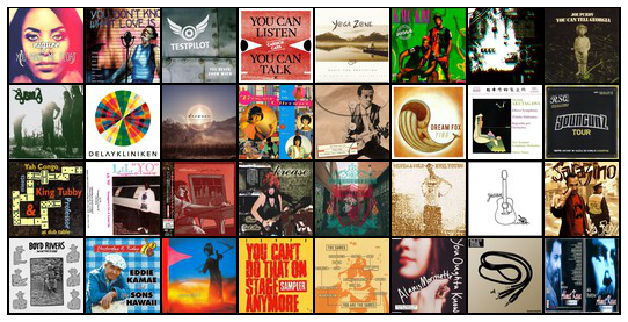

In [53]:
show(make_grid(real_cpu.cpu())) #show some real data

In [54]:
fake = netG(fixed_noise)
fake.data.size()

torch.Size([32, 3, 64, 64])

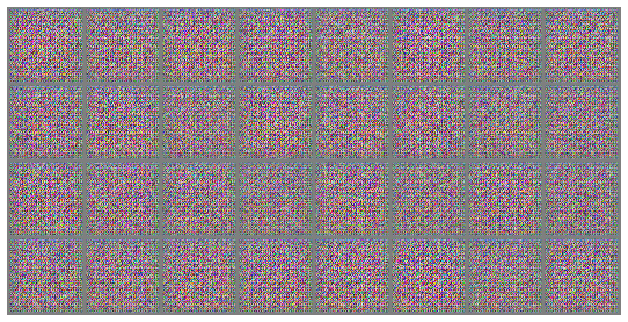

In [55]:
show(make_grid(fake.data.cpu())) # show some fake data. It should look bad for an untrained model

In [56]:
use_cuda=True
for epoch in range(niter):
    print('Epoch %s' % epoch)
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if use_cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()


        #if i % 50 == 0:
        #    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
        #          % (epoch, niter, i, len(dataloader),
        #             errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        
        

        if i % 100 == 0:
            #vutils.save_image(real_cpu,'%s/real_samples.png' % outf,normalize=True)
            fake = netG(fixed_noise)
            #show(make_grid(fake.data.cpu()))
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
        
        #include code to show current fake output so you have idea of where training is

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34


In [57]:
# do checkpointing
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

In [60]:
noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)
fake.size()

torch.Size([32, 3, 64, 64])

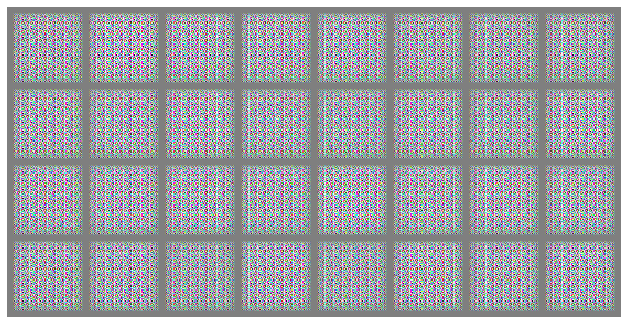

In [61]:
fake=fake.cpu()
show(make_grid(fake.data, padding=5))